# Seattle Traffic Collision Data
### Rebecca Stewart

## Analysis of numeric features that represent counts:

#### Features that represent number of people involved in the collision
- personcount - the total number of people involved
- pedcount- the total number of pedestrians involved
- pedcylcount - the total number of cyclists involved

#### Features that represent number of vehicles involved in the collision
- vehcount - the total number of vehicles involved

#### Features that represent number of injuries resulting from collision
- injuries - the total number of injuries other than fatal or disabling at the scene, including broken fingers or toes, abrasions, etc.
- seriousinjuries - total number of injuries that result in at least a temporary impairment, e.g. a broken limb. It does not mean that the collision resulted in a permanent disability
- fatalities - includes the total number of persons who died at the scene of the collisions, were dead on arrival at the hospital, or died within 30 days of the collision from collision-related injuries

#### Other interesting features that might relate to or give insight on these counts
- severitydesc - a description of the collision, e.g. Property Damage Only Collision, Injury Collision
- collisiontype - a description of the collision type, e.g. Parked Car, Rear Ended, Sideswipe
- sdot_coldesc - a description of the collision corresponding to the collision code (Motor Vehicle Struck Motor Vehicle, Rear End)
- st_colddesc -  - a description that corresponds to the state’s coding designation (Vehicle Going Straight Hits Pedestrian)
- hitparkedcar - hit parked car - Y/N
- crosswalkkey - a key for the crosswalk at which the collision occurred
- pedrownotgrnt - whether or not the pedestrian right of way was not granted. (Y/N)

#### Initial questions I am going to try and answer below;
1. Does personcount include pedcount?
2. Does personcount include pedcylcount?
3. Does injuries include seriousinjuries?
4. Does injuries include fatalities?
5. If the collision is marked as hitparkedcar = Y, does the 'number of vehicles involved' include the pared car?
6. Is there a consistent pattern involving severitydesc and injuries/seriousinjuries/fatalities
7. Is there a consistent pattern involving collisiontype and injuries/seriousinjuries/fatalities
8. Are there only values for pedrownotgrnt if pedcount > 0 or pedcylcount>0

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.style.use('ggplot')
pd.options.display.max_rows = 500
pd.options.display.max_columns = 100
import warnings
warnings.filterwarnings("ignore") 
from datetime import datetime

from IPython.display import display, Markdown
# Display all output within each cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

### Load data

In [27]:
# READ IN THE DATA FROM THE LOCAL CSV FILE
local_file_name  = "../data/collisions_orig.csv"
df = pd.read_csv(local_file_name , parse_dates=["INCDTTM"])

In [28]:
print("original df shape:", df.shape)

original df shape: (220436, 40)


In [29]:
# CHANGE CASE OF FEATURE NAMES  

df.drop(['EXCEPTRSNCODE', 'EXCEPTRSNDESC', 'STATUS', 'REPORTNO', 'SEGLANEKEY', 'CROSSWALKKEY', 'INCKEY','COLDETKEY'],axis=1, inplace=True)
df.columns = map(str.lower, df.columns)
df.head(3)

,x,y,objectid,addrtype,intkey,location,severitycode,severitydesc,collisiontype,personcount,pedcount,pedcylcount,vehcount,injuries,seriousinjuries,fatalities,incdate,incdttm,junctiontype,sdot_colcode,sdot_coldesc,inattentionind,underinfl,weather,roadcond,lightcond,pedrownotgrnt,sdotcolnum,speeding,st_colcode,st_coldesc,hitparkedcar
0,-122.340472,47.608629,1,Intersection,29598.0,PIKE PL AND PIKE ST,2,Injury Collision,Pedestrian,2,1,0,1,1,0,0,2004/10/14 00:00:00+00,2004-10-14 18:36:00,At Intersection (intersection related),24.0,MOTOR VEHCILE STRUCK PEDESTRIAN,NaN,0,Overcast,Dry,Dark - Street Lights On,NaN,4288030.0,NaN,3,Vehicle backing hits pedestrian,N
1,-122.251788,47.508176,2,Block,NaN,S PRENTICE ST BETWEEN 65TH AVE S AND 66TH AVE S,1,Property Damage Only Collision,NaN,2,0,0,0,0,0,0,2020/01/22 00:00:00+00,2020-01-22 00:00:00,Mid-Block (not related to intersection),12.0,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, RIGHT SIDE...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,NaN,Y
2,-122.328526,47.703180,3,Intersection,37555.0,1ST AVE NE AND NE 103RD ST,1,Property Damage Only Collision,Angles,4,0,0,2,0,0,0,2020/01/05 00:00:00+00,2020-01-05 13:28:00,At Intersection (intersection related),11.0,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...",NaN,N,Raining,Wet,Daylight,NaN,NaN,NaN,10,Entering at angle,N


### Feature Engineering

In [32]:
df["incdate"] = df["incdate"].astype("datetime64")
df["year"] = pd.DatetimeIndex(df.incdate).year  # alternate method
df["month"] = df["incdate"].map(lambda x: x.strftime('%m'))
df["time"]=df['incdttm'].dt.strftime('%H:%M')
df["total_injuries"]=df['injuries'] + df['seriousinjuries']  + df['fatalities'] 
df["total_person_count"]=df['personcount'] + df['pedcount']  + df['pedcylcount'] 

fe_emd_crit = (df['weather'].isnull() &
    df['lightcond'].isnull() &
    df['roadcond'].isnull() &
    df['collisiontype'].isnull() &
    df['st_coldesc'].isnull() &
    df['underinfl'].isnull() &
    df['inattentionind'].isnull() &
    df['speeding'].isnull() &
    df['pedrownotgrnt'].isnull() &
    (df['vehcount'] == 0))
df['fe_emd'] = fe_emd_crit

#### Initial Analysis of missing data 
Look at NaN for certain features

### LIGHTCOND, ROADCOND, WEATHER AND ST_COLDDESC = Nan, VEHCOUNT AND PERSONCOUNT=0
### Look at Nulls, Zeros and Unknowns for Full Dataset

In [33]:
# FOR THE ENTIRE DATASET
print("lightcond NaN   " + str(df["lightcond"].isna().sum()))
print("roadcond NaN   " + str(df["roadcond"].isna().sum()))
print("weather NaN   " + str(df["weather"].isna().sum()))
print("sdot_coldesc NEI   " + str(len(df[df["sdot_coldesc"]=="NOT ENOUGH INFORMATION / NOT APPLICABLE"])))
print("st_coldesc NaN   " + str(df["st_coldesc"].isna().sum()))
print("severitydesc unknown   " + str(len(df[df["severitydesc"]=="Unknown"])))
print("vehcount zero   " + str(len(df[df["vehcount"]==0])))
print("total_person_count zero   " + str(len(df[df["total_person_count"]==0])))
print("time is  00:00  " + str(len(df[df["time"]=="00:00"])))
print("underinfl NaN   " + str(df["underinfl"].isna().sum()))

lightcond NaN   26429
roadcond NaN   26260
weather NaN   26340
sdot_coldesc NEI   19103
st_coldesc NaN   26152
severitydesc unknown   21510
vehcount zero   26375
total_person_count zero   24510
time is  00:00  52204
underinfl NaN   26132


### LIGHTCOND, ROADCOND, WEATHER AND ST_COLDDESC = Nan, VEHCOUNT AND PERSONCOUNT=0
### Look at Nulls, Zeros and Unknowns when lightcond is Null

In [34]:
# FOR JUST THOSE THAT HAVE LIGHTCOND MISSING
df_no_light = df[df["lightcond"].isna()]
print("lightcond NaN   " + str(df_no_light["lightcond"].isna().sum()))
print("roadcond NaN   " + str(df_no_light["roadcond"].isna().sum()))
print("weather NaN   " + str(df_no_light["weather"].isna().sum()))
print("sdot_coldesc NEI   " + str(len(df_no_light[df_no_light["sdot_coldesc"]=="NOT ENOUGH INFORMATION / NOT APPLICABLE"])))
print("st_coldesc NaN   " + str(df_no_light["st_coldesc"].isna().sum()))
print("severitydesc unknown   " + str(len(df_no_light[df_no_light["severitydesc"]=="Unknown"])))
print("vehcount zero   " + str(len(df_no_light[df_no_light["vehcount"]==0])))
print("total_person_count zero   " + str(len(df_no_light[df_no_light["total_person_count"]==0])))
print("time is  00:00  " + str(len(df_no_light[df_no_light["time"]=="00:00"])))
print("underinfl NaN   " + str(df_no_light["underinfl"].isna().sum()))


lightcond NaN   26429
roadcond NaN   26200
weather NaN   26207
sdot_coldesc NEI   10102
st_coldesc NaN   26130
severitydesc unknown   21508
vehcount zero   26133
total_person_count zero   19355
time is  00:00  26133
underinfl NaN   26131


The null counts for this subset are almost the same as the entire dataset. These should clearly be grouped togeather w/ fe_emd_null = True 

### LIGHTCOND, ROADCOND, WEATHER = "UNKNOWN" AND ST_COLDDESC = "NEI"
### For Full Dataset

In [35]:
print("lightcond unknown   " + str(len(df[df["lightcond"]=="Unknown"])))
print("roadcond unknown   " + str(len(df[df["roadcond"]=="Unknown"])))
print("weather unknown   " + str(len(df[df["weather"]=="Unknown"])))
print("sdot_coldesc NEI   " + str(len(df[df["sdot_coldesc"]=="NOT ENOUGH INFORMATION / NOT APPLICABLE"])))
print("severitydesc unknown   " + str(len(df[df["severitydesc"]=="Unknown"])))
print("time is  00:00  " + str(len(df[df["time"]=="00:00"])))
print("underinfl NaN   " + str(df["underinfl"].isna().sum()))

lightcond unknown   13518
roadcond unknown   15129
weather unknown   15131
sdot_coldesc NEI   19103
severitydesc unknown   21510
time is  00:00  52204
underinfl NaN   26132


### LIGHTCOND, ROADCOND, WEATHER = "UNKNOWN" AND ST_COLDDESC = "NEI"
### For data where lightcond is UNKNOWN

In [36]:
df_light_unknown = df[df["lightcond"]=="Unknown"]
print("lightcond unknown   " + str(len(df_light_unknown[df_light_unknown["lightcond"]=="Unknown"])))
print("roadcond unknown   " + str(len(df_light_unknown[df_light_unknown["roadcond"]=="Unknown"])))
print("weather unknown   " + str(len(df_light_unknown[df_light_unknown["weather"]=="Unknown"])))
print("sdot_coldesc NEI   " + str(len(df_light_unknown[df_light_unknown["sdot_coldesc"]=="NOT ENOUGH INFORMATION / NOT APPLICABLE"])))
print("st_coldesc NaN   " + str(df_light_unknown["st_coldesc"].isna().sum()))
print("vehcount zero   " + str(len(df_light_unknown[df_light_unknown["vehcount"]==0])))
print("total_person_count zero   " + str(len(df_light_unknown[df_light_unknown["total_person_count"]==0])))
print("severitydesc unknown   " + str(len(df_light_unknown[df_light_unknown["severitydesc"]=="Unknown"])))
print("time is  00:00  " + str(len(df_light_unknown[df_light_unknown["time"]=="00:00"])))
print("underinfl NaN   " + str(df_light_unknown["underinfl"].isna().sum()))

lightcond unknown   13518
roadcond unknown   10650
weather unknown   10723
sdot_coldesc NEI   4140
st_coldesc NaN   2
vehcount zero   1
total_person_count zero   151
severitydesc unknown   0
time is  00:00  2006
underinfl NaN   0


In [37]:
print(len(df[df['hitparkedcar'] == 'Y'])/len(df))
print(len(df_no_light[df_no_light['hitparkedcar'] == 'Y'])/len(df_no_light))
print(len(df_light_unknown[df_light_unknown['hitparkedcar'] == 'Y'])/len(df_light_unknown))

0.0534168647589323
0.17893223353134813
0.11014943038911082


### Look at Null and Unique Values for Various Features

In [40]:
other_cols = ["roadcond", "weather",  "collisiontype", "severitycode", "severitydesc",  'addrtype', 'junctiontype', 'inattentionind', 'underinfl', 'pedrownotgrnt', 'speeding', 'hitparkedcar']
for col in other_cols:
    print("-"*20)
    print(col)
    print("NaN   " + str(df[col].isna().sum()))
    print(df[col].value_counts())

--------------------
roadcond
NaN   26260
Dry               127753
Wet                48653
Unknown            15129
Ice                 1231
Snow/Slush          1014
Other                136
Standing Water       119
Sand/Mud/Dirt         77
Oil                   64
Name: roadcond, dtype: int64
--------------------
weather
NaN   26340
Clear                       114006
Raining                      33973
Overcast                     28435
Unknown                      15131
Snowing                        919
Other                          850
Fog/Smog/Smoke                 576
Sleet/Hail/Freezing Rain       116
Blowing Sand/Dirt               56
Severe Crosswind                26
Partly Cloudy                    8
Name: weather, dtype: int64
--------------------
collisiontype
NaN   26152
Parked Car    48364
Angles        35366
Rear Ended    34545
Other         24450
Sideswipe     18812
Left Turn     14047
Pedestrian     7637
Cycles         5893
Right Turn     2998
Head On        2172
Nam

#### Time - Total and percent missing values 

In [41]:

df_no_time = df[df["time"]=="00:00"]
print("Total Missing   " + str(len(df_no_time)))
print("Portion of values that are missing")
print(len(df_no_time)/len(df))

Total Missing   52204
Portion of values that are missing
0.2368215717940808


####  st_coldesc and  sdot_col - Null values 

In [42]:

#print(df["sdot_col"].value_counts().sort_index())
#print(df["sdot_coldesc"].value_counts().sort_index())
print("Null values for st_coldesc " + str(df["sdot_coldesc"].isna().sum()))
print("Null values for sdot_col " + str(df["st_coldesc"].isna().sum()))

Null values for st_coldesc 1
Null values for sdot_col 26152


In [73]:
#LOOK AT THE FIRST FEW ROWS OR THE COLUMNS WE ARE INTERESTED IN
num_count_cols=['personcount','pedcount','pedcylcount','vehcount','injuries','seriousinjuries','fatalities', 'total_injuries']
interest_cols=['severitydesc','collisiontype','sdot_coldesc','st_coldesc','hitparkedcar','pedrownotgrnt']

display(df[num_count_cols].head(10))

,personcount,pedcount,pedcylcount,vehcount,injuries,seriousinjuries,fatalities,total_injuries
0,2,1,0,1,1,0,0,1
1,2,0,0,0,0,0,0,0
2,4,0,0,2,0,0,0,0
3,2,0,0,2,0,0,0,0
4,0,0,0,0,0,0,0,0
5,2,0,0,0,1,0,0,1
6,2,0,0,2,0,0,0,0
7,2,0,0,0,0,0,0,0
8,2,0,0,2,0,0,0,0
9,4,0,0,2,0,0,0,0


### 1. Person Counts - Includes  personcount, pedcount (pedestrians) and pedcyclcount (cyclists) 

The following table shows record count for each combination counts for persons, pedestrians and cyclists.

In [74]:
df.groupby(['personcount','pedcount','pedcylcount']).size().reset_index().rename(columns={0:'record count'}).head(25)

,personcount,pedcount,pedcylcount,record count
0,0,0,0,24510
1,0,0,1,187
2,0,0,2,2
3,0,1,0,216
4,0,1,1,1
5,0,2,0,11
6,0,2,1,1
7,1,0,0,13513
8,1,0,1,241
9,1,0,2,1


At a glance, it's concerning to see how many records have zero for each of these person counts. We will revisit this below (1.2).

#### 1.1 Questions 1 & 2 combined "Does personcount include pedcount or pedcylcount?" answer to both is no, they are not included.
Since there are many records that have pedcount (pedestrian count) and/or pedcylcount (cyclist) greater than zero, while personcount is zero, it is clear that personcount does not automatically include pedcount (pedestrian count) or pedcylcount (cyclist).

####  Interesting Follow-up Question
There are 24,540 collisions where no people at all were involved. What kind of accidents would account for this?

#### 1.2 Analyze records where all person counts are zero

We will create two subsets of data, those were all person counts are zero, and another, where at least one person count is greater than zero. We can use these to compare counts in different related features to see if there is a pattern.

In [75]:
# Create a dataset of just those collisions where supposedly no people were involved
df_no_people = df.loc[(df["personcount"] == 0) & (df["pedcount"] == 0) & (df["pedcylcount"] == 0)]
df_one_or_more_people = df.loc[(df["personcount"] > 0) | (df["pedcount"] > 0) | (df["pedcylcount"] > 0)]
df_no_people[['vehcount','injuries','seriousinjuries','fatalities', 'severitydesc','collisiontype','sdot_coldesc','st_coldesc','hitparkedcar','pedrownotgrnt']].head(5)



,vehcount,injuries,seriousinjuries,fatalities,severitydesc,collisiontype,sdot_coldesc,st_coldesc,hitparkedcar,pedrownotgrnt
4,0,0,0,0,Unknown,NaN,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...",NaN,Y,NaN
12,0,0,0,0,Unknown,NaN,NOT ENOUGH INFORMATION / NOT APPLICABLE,NaN,N,NaN
15,0,0,0,0,Unknown,NaN,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...",NaN,Y,NaN
25,0,0,0,0,Unknown,NaN,NOT ENOUGH INFORMATION / NOT APPLICABLE,NaN,Y,NaN
31,0,0,0,0,Unknown,NaN,NOT ENOUGH INFORMATION / NOT APPLICABLE,NaN,Y,NaN


#### Something strange is going on here...
It looks like these are real collisions involving vehicles, but people counts, vehicle counts and injury counts are all zeros. This represents about 10% of our data. Need to keep this in mind when analysis includes vehcount and/or person counts. Might want to drop records that are zero for all these counts.  

#### A further look at this subset of data:
How can there be no people involved if there are vehicles and/or injuries involved?

In [76]:
print("Severity of collisions for those when supposedly no people were involved - most of these are listed as Unknown")
df_no_people['severitydesc'].value_counts()

Severity of collisions for those when supposedly no people were involved - most of these are listed as Unknown


Unknown                           19349
Property Damage Only Collision     3741
Injury Collision                   1400
Serious Injury Collision             19
Fatality Collision                    1
Name: severitydesc, dtype: int64

#### 1.3 Severity comparison

Most of the records where number of people are involved = zero, Severity is listed as Unknown

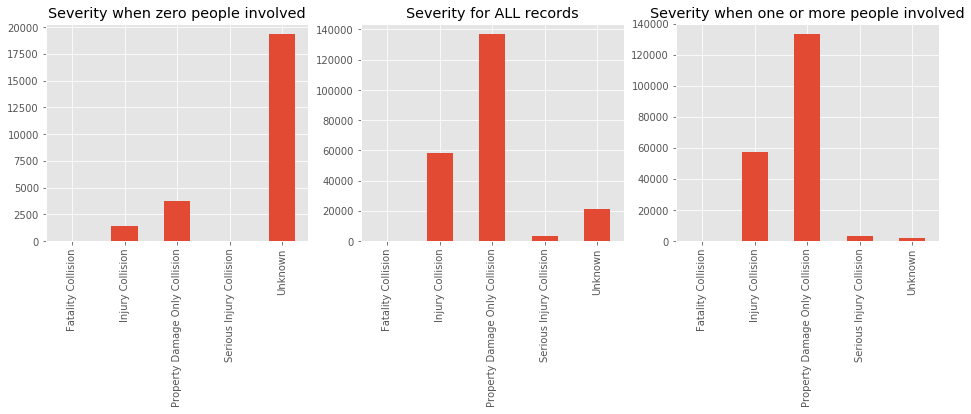

In [77]:
fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 4))
fig.subplots_adjust(hspace=0.8)

df_no_people['severitydesc'].value_counts().sort_index().plot(ax=axes[0],kind='bar',title='Severity when zero people involved')
df['severitydesc'].value_counts().sort_index().plot(ax=axes[1],kind='bar',title='Severity for ALL records')
df_one_or_more_people['severitydesc'].value_counts().sort_index().plot(ax=axes[2],kind='bar',title='Severity when one or more people involved')

Maybe we should remove records where number of people involved = zero

#### 1.4  Vehicle count comparison

Lets next look at vehicle count when number of people involved is zero

In [78]:
print("Number of records where zero, one or more vehicles were involved when no people were involved")
df_no_people['vehcount'].value_counts()

Number of records where zero, one or more vehicles were involved when no people were involved


0     19352
2      4266
3       391
1       391
4        81
5        19
6         6
7         2
11        1
9         1
Name: vehcount, dtype: int64

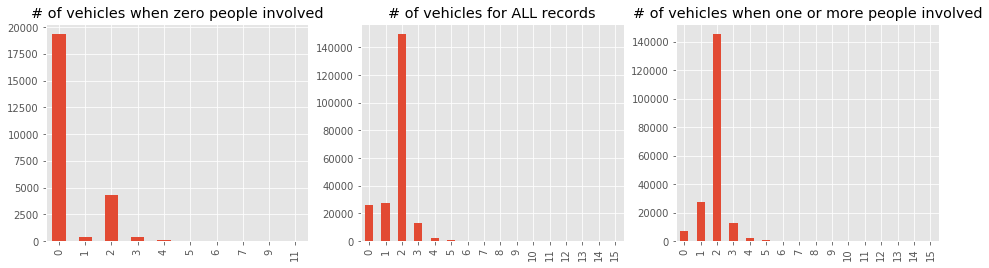

In [79]:
fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 4))
fig.subplots_adjust(hspace=0.8)

df_no_people['vehcount'].value_counts().sort_index().plot(ax=axes[0],kind='bar',title='# of vehicles when zero people involved')
df['vehcount'].value_counts().sort_index().plot(ax=axes[1],kind='bar',title='# of vehicles for ALL records')
df_one_or_more_people['vehcount'].value_counts().sort_index().plot(ax=axes[2],kind='bar',title='# of vehicles when one or more people involved')

#### 1.5  Injury count comparison

In [80]:
print("Number of records where there were zero, one or more injuries when no people were involved")
df_no_people['injuries'].value_counts()

Number of records where there were zero, one or more injuries when no people were involved


0    23092
1     1052
2      269
3       64
4       21
5        9
9        1
8        1
6        1
Name: injuries, dtype: int64

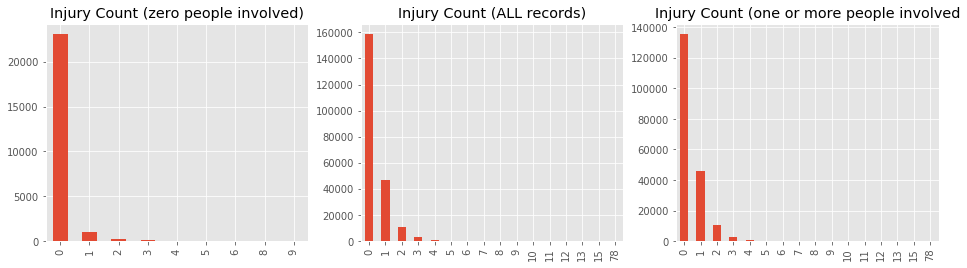

In [81]:
fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 4))
fig.subplots_adjust(hspace=0.8)

df_no_people['injuries'].value_counts().sort_index().plot(ax=axes[0],kind='bar',title='Injury Count (zero people involved)')
df['injuries'].value_counts().sort_index().plot(ax=axes[1],kind='bar',title='Injury Count (ALL records)')
df_one_or_more_people['injuries'].value_counts().sort_index().plot(ax=axes[2],kind='bar',title='Injury Count (one or more people involved')

#### 1.6  Collision Type comparison

In [82]:
print("Collisiontype for collisions for those when supposedly no people were involved - most of these are listed as Unknown")
df_no_people['collisiontype'].value_counts()


Collisiontype for collisions for those when supposedly no people were involved - most of these are listed as Unknown


Angles        1223
Parked Car    1111
Rear Ended    1038
Sideswipe      614
Other          584
Left Turn      432
Right Turn      94
Head On         63
Name: collisiontype, dtype: int64

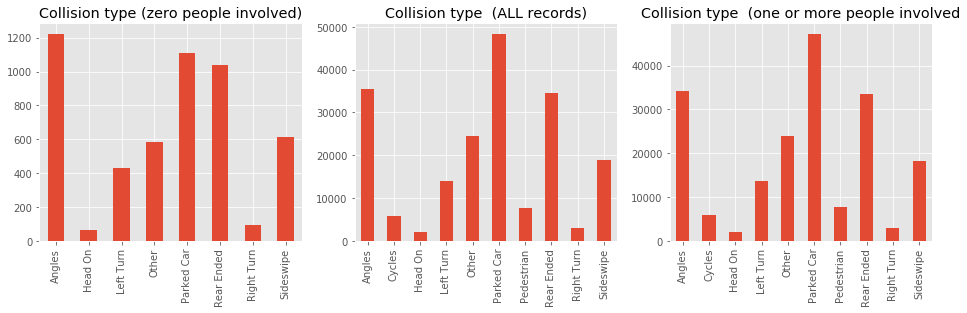

In [83]:
fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 4))
fig.subplots_adjust(hspace=0.8)

df_no_people['collisiontype'].value_counts().sort_index().plot(ax=axes[0],kind='bar',title='Collision type (zero people involved)')
df['collisiontype'].value_counts().sort_index().plot(ax=axes[1],kind='bar',title='Collision type  (ALL records)')
df_one_or_more_people['collisiontype'].value_counts().sort_index().plot(ax=axes[2],kind='bar',title='Collision type  (one or more people involved')

#### 1.7  Collision Description comparison

In [84]:
print("Descriptions for collisions for those when supposedly no people were involved - most of these are listed as Not Enough Info")
df_no_people['sdot_coldesc'].value_counts()


Descriptions for collisions for those when supposedly no people were involved - most of these are listed as Not Enough Info


NOT ENOUGH INFORMATION / NOT APPLICABLE                         8265
MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END AT ANGLE          7338
MOTOR VEHICLE STRUCK MOTOR VEHICLE, REAR END                    5682
MOTOR VEHICLE STRUCK MOTOR VEHICLE, LEFT SIDE SIDESWIPE         1021
MOTOR VEHICLE STRUCK MOTOR VEHICLE, LEFT SIDE AT ANGLE           626
MOTOR VEHICLE RAN OFF ROAD - HIT FIXED OBJECT                    490
MOTOR VEHICLE STRUCK OBJECT IN ROAD                              321
MOTOR VEHICLE STRUCK MOTOR VEHICLE, RIGHT SIDE SIDESWIPE         209
MOTOR VEHICLE STRUCK MOTOR VEHICLE, RIGHT SIDE AT ANGLE          180
MOTOR VEHCILE STRUCK PEDESTRIAN                                  160
MOTOR VEHICLE STRUCK PEDALCYCLIST, FRONT END AT ANGLE             70
MOTOR VEHICLE OVERTURNED IN ROAD                                  38
PEDALCYCLIST STRUCK MOTOR VEHICLE FRONT END AT ANGLE              26
DRIVERLESS VEHICLE RAN OFF ROAD - HIT FIXED OBJECT                12
MOTOR VEHICLE RAN OFF ROAD - NO CO

In [85]:
print("Descriptions for collisions for those when at least one person was involved")
df_one_or_more_people['sdot_coldesc'].value_counts()

Descriptions for collisions for those when at least one person was involved


MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END AT ANGLE                  84250
MOTOR VEHICLE STRUCK MOTOR VEHICLE, REAR END                            53308
NOT ENOUGH INFORMATION / NOT APPLICABLE                                 10838
MOTOR VEHICLE STRUCK MOTOR VEHICLE, LEFT SIDE SIDESWIPE                  9882
MOTOR VEHICLE RAN OFF ROAD - HIT FIXED OBJECT                            9040
MOTOR VEHCILE STRUCK PEDESTRIAN                                          7513
MOTOR VEHICLE STRUCK MOTOR VEHICLE, LEFT SIDE AT ANGLE                   6236
MOTOR VEHICLE STRUCK OBJECT IN ROAD                                      4733
MOTOR VEHICLE STRUCK PEDALCYCLIST, FRONT END AT ANGLE                    3342
MOTOR VEHICLE STRUCK MOTOR VEHICLE, RIGHT SIDE SIDESWIPE                 1594
MOTOR VEHICLE STRUCK MOTOR VEHICLE, RIGHT SIDE AT ANGLE                  1592
PEDALCYCLIST STRUCK MOTOR VEHICLE FRONT END AT ANGLE                     1442
MOTOR VEHICLE OVERTURNED IN ROAD                                


For analysis involving counts, collision type and descriptions, might recommend removing records where people counts, vehicle counts and injury counts are all zeros and collision type and description are both 'Unknown'.

### 2. Vehicle Counts - This should be number of vehicles involved in the collision

In [86]:
df.groupby(['vehcount','personcount']).size().reset_index().rename(columns={0:'count'}).head(30)

,vehcount,personcount,count
0,0,0,19357
1,0,1,1816
2,0,2,4666
3,0,3,359
4,0,4,177
5,1,0,790
6,1,1,11831
7,1,2,12221
8,1,3,2061
9,1,4,538


2.1.1 Let's look closer at those records where all these counts are zero...

In [87]:
df_zero_counts = df.loc[(df["personcount"] == 0) & (df["pedcount"] == 0) & (df["pedcylcount"] == 0)& (df["vehcount"] == 0)]

In [88]:
df_zero_counts.head(3)

,x,y,objectid,addrtype,intkey,location,severitycode,severitydesc,collisiontype,personcount,pedcount,pedcylcount,vehcount,injuries,seriousinjuries,fatalities,incdate,incdttm,junctiontype,sdot_colcode,sdot_coldesc,inattentionind,underinfl,weather,roadcond,lightcond,pedrownotgrnt,sdotcolnum,speeding,st_colcode,st_coldesc,hitparkedcar,year,month,time,total_injuries,total_person_count,fe_emd
4,-122.366178,47.669041,5,Block,NaN,8TH AVE NW BETWEEN NW MARKET ST AND NW 56TH ST,0,Unknown,NaN,0,0,0,0,0,0,0,2020-02-08,2020-02-08,Mid-Block (not related to intersection),11.0,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,NaN,Y,2020,02,00:00,0,0,True
12,-122.378789,47.560171,13,Block,NaN,37TH AVE SW BETWEEN SW ALASKA ST AND SW EDMUND...,0,Unknown,NaN,0,0,0,0,0,0,0,2016-01-21,2016-01-21,Mid-Block (not related to intersection),0.0,NOT ENOUGH INFORMATION / NOT APPLICABLE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,NaN,N,2016,01,00:00,0,0,True
15,-122.344977,47.723212,16,Intersection,35828.0,AURORA AVE N AND N 130TH ST,0,Unknown,NaN,0,0,0,0,0,0,0,2020-02-15,2020-02-15,At Intersection (intersection related),11.0,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,NaN,Y,2020,02,00:00,0,0,True


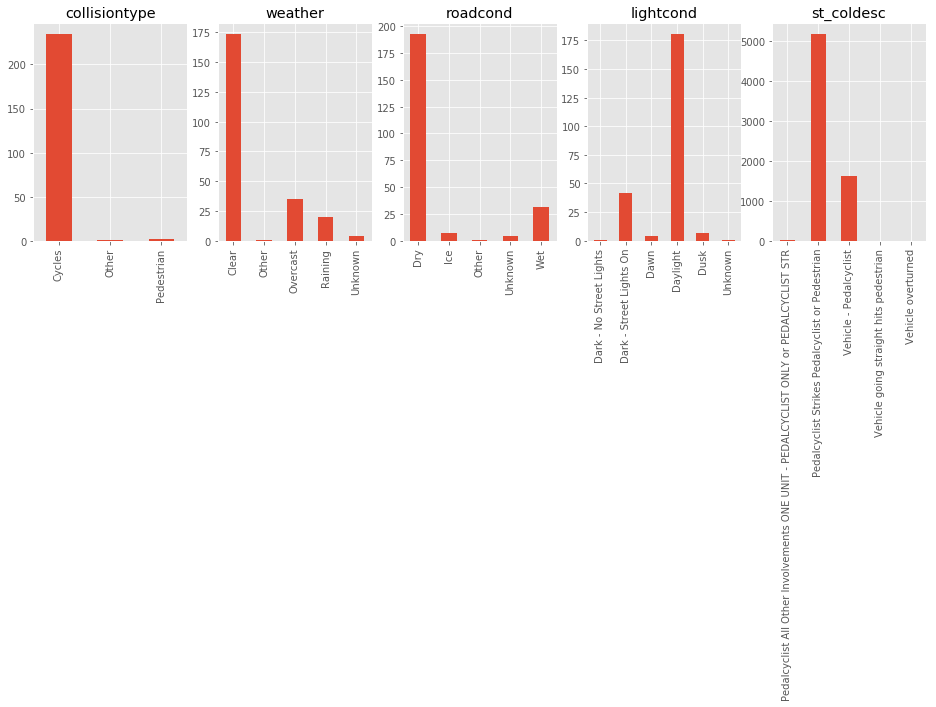

In [89]:

df_no_vehicle = df.loc[(df["vehcount"] == 0) & (df["personcount"]> 0) ]
fig, axes = plt.subplots(figsize=(16, 4) , nrows = 1, ncols = 5)
fig.subplots_adjust(hspace=0.8)


cols_to_look_at = [ 'addrtype' ,'collisiontype' ,
                    'weather', 'roadcond', 'lightcond', 
                   'st_coldesc']

for i, col in enumerate(cols_to_look_at):
    ax = axes[i-1]
    df_no_vehicle[col].value_counts().sort_index().plot(ax=ax,kind='bar',title=col)
    



The value 'Unknown' dominates for collisiontype, weather, roadcond and lightcond. Let's include st_coldesc=Unknown in this set of records. This makes up almost 20k of our dataset. Almost all also have Unknown for severity code.

#### 2.1.2 Analysis of Vehicle Count = zero, but personcount was greater than zero

Since we have already looked at those records where person count and vehicle count are both zero, let's just look at those where person count is greater than zero

In [90]:
df_no_vehicle = df.loc[(df["vehcount"] == 0) & (df["personcount"]> 0) ]
df_one_or_more_vehicle= df.loc[(df["vehcount"] > 0) & (df["personcount"]> 0) ]

#### 2.2 Collision Type for the two sets of data (those where vehicle count = zero and those where vehicle count >zero)

Since we have already looked at those records where person count and vehicle count are both zero, let's just look at those where person count is greater than zero

In [91]:
print("collisiontype for those when supposedly no vehicles were involved")
df_no_vehicle['collisiontype'].value_counts()


collisiontype for those when supposedly no vehicles were involved


Cycles        235
Pedestrian      2
Other           1
Name: collisiontype, dtype: int64

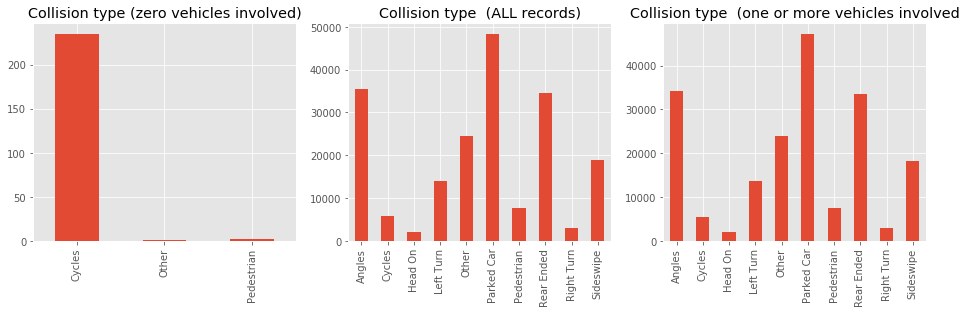

In [92]:
fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 4))
fig.subplots_adjust(hspace=0.8)

df_no_vehicle['collisiontype'].value_counts().sort_index().plot(ax=axes[0],kind='bar',title='Collision type (zero vehicles involved)')
df['collisiontype'].value_counts().sort_index().plot(ax=axes[1],kind='bar',title='Collision type  (ALL records)')
df_one_or_more_vehicle['collisiontype'].value_counts().sort_index().plot(ax=axes[2],kind='bar',title='Collision type  (one or more vehicles involved')

I'm not surprised that most of these are marked as Unknown, that may be why number of vehicles = 0, they just didn't know how many were involved, and so listed zero instead of 'unknown'.

#### 2.3 Severity for these two sets of data

In [93]:
print("severitydesc for collisions for those when supposedly no vehicles were involved")
df_no_vehicle['severitydesc'].value_counts()

severitydesc for collisions for those when supposedly no vehicles were involved


Property Damage Only Collision    3630
Unknown                           2160
Injury Collision                  1134
Serious Injury Collision            85
Fatality Collision                   9
Name: severitydesc, dtype: int64

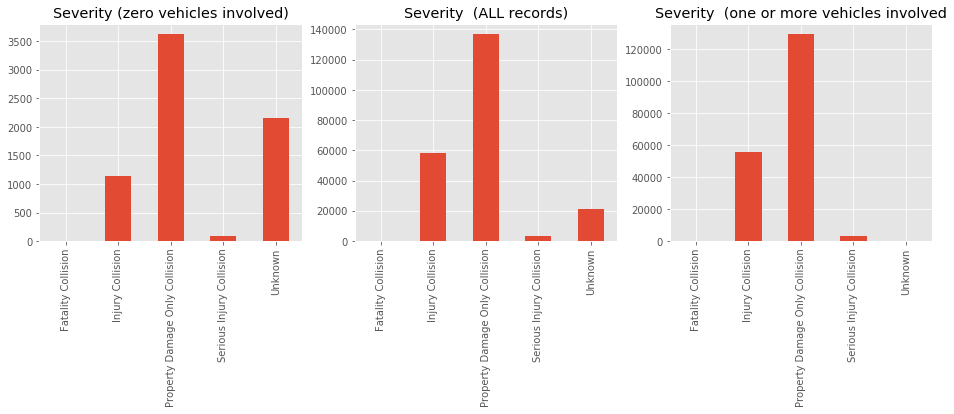

In [94]:
fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 4))
fig.subplots_adjust(hspace=0.8)

df_no_vehicle['severitydesc'].value_counts().sort_index().plot(ax=axes[0],kind='bar',title='Severity (zero vehicles involved)')
df['severitydesc'].value_counts().sort_index().plot(ax=axes[1],kind='bar',title='Severity  (ALL records)')
df_one_or_more_vehicle['severitydesc'].value_counts().sort_index().plot(ax=axes[2],kind='bar',title='Severity  (one or more vehicles involved')

#### 2.4 Hit parked car for those where vehicle count=zero, but personcount was greater than zero

I would guess that 'Property Damage Only Collision' and 'Unknown' are collisions that were reported after the fact, which probably means certain data was not collected, like how many vehicles were involved. Again, defaulting to zero instead of 'unknown'.

In [95]:
print("hitparkedcar for collisions for those when supposedly no vehicles were involved")
df_no_vehicle['hitparkedcar'].value_counts()

hitparkedcar for collisions for those when supposedly no vehicles were involved


N    5636
Y    1382
Name: hitparkedcar, dtype: int64

#### 2.4 Collision descriptions for those where vehicle count=zero, but personcount was greater than zero

Clearly those collision records where a parked car was hit should have vehicle count of at least 2 (unless it was a bicycle hitting a parked car), in which case it should be at least 1.

In [96]:
df_no_vehicle['sdot_coldesc'].value_counts()

NOT ENOUGH INFORMATION / NOT APPLICABLE                                 2017
MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END AT ANGLE                  1936
MOTOR VEHICLE STRUCK MOTOR VEHICLE, REAR END                            1585
MOTOR VEHICLE STRUCK MOTOR VEHICLE, LEFT SIDE AT ANGLE                   507
MOTOR VEHICLE STRUCK MOTOR VEHICLE, RIGHT SIDE AT ANGLE                  173
MOTOR VEHICLE STRUCK MOTOR VEHICLE, LEFT SIDE SIDESWIPE                  147
MOTOR VEHCILE STRUCK PEDESTRIAN                                          124
MOTOR VEHICLE RAN OFF ROAD - HIT FIXED OBJECT                             96
MOTOR VEHICLE STRUCK PEDALCYCLIST, FRONT END AT ANGLE                     86
PEDALCYCLIST STRUCK PEDESTRIAN                                            81
MOTOR VEHICLE STRUCK OBJECT IN ROAD                                       81
PEDALCYCLIST OVERTURNED IN ROAD                                           62
MOTOR VEHICLE STRUCK MOTOR VEHICLE, RIGHT SIDE SIDESWIPE                  41

We could use this information to update vehicle count to some number other than zero (accept the NEI records)

#### <i>RECOMMENDATION</i>

First, I recommend updating vehicle count base on collision descriptions. For those that include "MOTOR VEHICLE" twice, we can update this count to two. For those that only include one occurrence of "MOTOR VEHICLE", update this count to one. 

Second, I recommend removing all records where vehicle count is zero, sdot_coldesc= "NOT ENOUGH INFORMATION / NOT APPLICABLE" and collision type is not 'cycles'.

Third, for those where hitparkedcar=True (and does not involve a cyclist) we update vehicle count = 2

#### 2.5  On second thought, lets look at percentage of records that involve 3 or more vehicles...

In [97]:
df_three_or_more_veh = df[df['vehcount']>2]
df_at_least_one= df[df['vehcount']>0]
percent_three_or_more=round((df_three_or_more_veh.shape[0]/df_at_least_one.shape[0])*100,2)
print("Percent of accidents that involve more than two vehicles " + str(percent_three_or_more) + "%")

Percent of accidents that involve more than two vehicles 8.56%


In [98]:
df[df['vehcount']>2]['sdot_coldesc'].value_counts().to_frame('count').head(15)

,count
"MOTOR VEHICLE STRUCK MOTOR VEHICLE, REAR END",8920
"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END AT ANGLE",5462
"MOTOR VEHICLE STRUCK MOTOR VEHICLE, LEFT SIDE SIDESWIPE",870
"MOTOR VEHICLE STRUCK MOTOR VEHICLE, LEFT SIDE AT ANGLE",576
NOT ENOUGH INFORMATION / NOT APPLICABLE,184
MOTOR VEHICLE RAN OFF ROAD - HIT FIXED OBJECT,182
MOTOR VEHICLE STRUCK OBJECT IN ROAD,119
"MOTOR VEHICLE STRUCK MOTOR VEHICLE, RIGHT SIDE SIDESWIPE",117
"MOTOR VEHICLE STRUCK MOTOR VEHICLE, RIGHT SIDE AT ANGLE",78
DRIVERLESS VEHICLE STRUCK MOTOR VEHICLE FRONT END AT ANGLE,22


It turns out that the number of times the words 'MOTOR VEHICLE' is found in the collision description is not necessarily the same as the number of vehicles actually involved in the collision.

### 3. Injury Counts - This includes injuries, seriousinjuries and fatalities

In [99]:
df.groupby(['injuries','seriousinjuries','fatalities']).size().reset_index().rename(columns={0:'count'})

,injuries,seriousinjuries,fatalities,count
0,0,0,0,158536
1,0,0,1,220
2,0,0,2,4
3,0,0,3,1
4,0,0,4,1
5,0,1,0,6
6,1,0,0,44736
7,1,0,1,49
8,1,0,2,1
9,1,1,0,2236


#### 3.1 Questions 3 & 4 combined "Does injuries include seriousinjuries or fatalities?" answer to both is no, they are not included.

Since there are records where injuries are zero and serious injuries and/or fatalities are greater than zero, we can assume that injuries does not include those that are serious or fatal.

#### *RECOMMENDATION*

I recommend that we create a new feature called Total Injuries, this would sum injuries, seriousinjuries and fatalities.

### 4. Other interesting questions

In [100]:
display(df[interest_cols].head(10))

,severitydesc,collisiontype,sdot_coldesc,st_coldesc,hitparkedcar,pedrownotgrnt
0,Injury Collision,Pedestrian,MOTOR VEHCILE STRUCK PEDESTRIAN,Vehicle backing hits pedestrian,N,NaN
1,Property Damage Only Collision,NaN,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, RIGHT SIDE...",NaN,Y,NaN
2,Property Damage Only Collision,Angles,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...",Entering at angle,N,NaN
3,Property Damage Only Collision,Sideswipe,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...",From same direction - both going straight - bo...,N,NaN
4,Unknown,NaN,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...",NaN,Y,NaN
5,Injury Collision,NaN,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...",NaN,N,NaN
6,Property Damage Only Collision,Other,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, REAR END",From same direction - all others,N,NaN
7,Property Damage Only Collision,NaN,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...",NaN,Y,NaN
8,Property Damage Only Collision,Other,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, REAR END",One car entering driveway access,N,NaN
9,Property Damage Only Collision,Left Turn,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...",From opposite direction - one left turn - one ...,N,NaN


#### 4.1 Hit Parked Car

If the collision is marked as hitparkedcar = Y, does the 'number of vehicles involved' include the pared car?

Let's only look at those where number of vehicles is greater than zero

In [101]:
pd.options.display.max_colwidth = 150
df_hit_parked_car = df.loc[(df["hitparkedcar"] == 'Y')]
df_hit_parked_car=df_hit_parked_car.loc[(df["vehcount"] >0)]
df_hit_parked_car.groupby(['vehcount','sdot_coldesc']).size().reset_index().rename(columns={0:'count'})

,vehcount,sdot_coldesc,count
0,1,DRIVERLESS VEHICLE RAN OFF ROAD - HIT FIXED OBJECT,1
1,1,MOTOR VEHCILE STRUCK PEDESTRIAN,1
2,1,MOTOR VEHICLE RAN OFF ROAD - HIT FIXED OBJECT,2
3,1,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END AT ANGLE",4
4,1,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, LEFT SIDE SIDESWIPE",2
5,1,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, REAR END",15
6,1,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, RIGHT SIDE AT ANGLE",1
7,1,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, RIGHT SIDE SIDESWIPE",1
8,1,MOTOR VEHICLE STRUCK OBJECT IN ROAD,1
9,1,"MOTOR VEHICLE STRUCK PEDALCYCLIST, REAR END",1


We can definitely see some inconsistencies where the vehicle count is one. Only some of these make sense – the ones where a cyclist runs into a vehicle, but most the others (even the ones where a driverless vehicle stuck another vehicle) seem like they should involve more than one vehicle.

#### Question: "If the collision is marked as hitparkedcar = Y, does the 'number of vehicles involved' include the pared car?" Answer; yes, it’s included.

Most of these records have vehicle count more than one, which leads me to believe that the parked car is almost always included in the vehicle count.

#### 4.2 Severity Description and Type of Injuries

First we will look at severity descriptions with those that have one or more injuries or fatalities

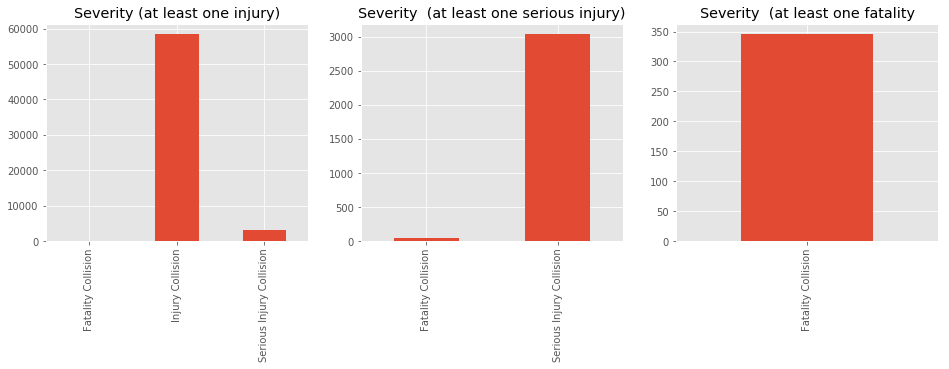

In [102]:
df_injury=  df.loc[(df["injuries"] > 0)]
df_serious_injury= df.loc[(df["seriousinjuries"] > 0)]
df_fatality= df.loc[(df["fatalities"] > 0)]

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 4))
fig.subplots_adjust(hspace=0.8)

df_injury['severitydesc'].value_counts().sort_index().plot(ax=axes[0],kind='bar',title='Severity (at least one injury)')
df_serious_injury['severitydesc'].value_counts().sort_index().plot(ax=axes[1],kind='bar',title='Severity  (at least one serious injury)')
df_fatality['severitydesc'].value_counts().sort_index().plot(ax=axes[2],kind='bar',title='Severity  (at least one fatality')

#### Question: "Is there a consistent pattern involving severitydesc and injuries/seriousinjuries/fatalities" - Answer; Yes, but with exceptions

Is there a consistent pattern involving severitydesc and injuries/seriousinjuries/fatalities? Yes, for the most part, however, there are a few inconsistencies. Some records list number of fatalities as zero, but include the value "fatality collision" for severity. And some records list seriousinjuries as zero but include the value "serious injury collision" for severity.

I will review a subset of these kinds of records to see if there is an indicator of what is causing these inconsistencies.

In [103]:
df_injury_maybe_serious=  df_injury.loc[(df_injury["severitydesc"] == "Serious Injury Collision") | (df_injury["severitydesc"] == "Fatality Collision")]
df_injury_maybe_serious[['injuries', 'vehcount','severitydesc','collisiontype','sdot_coldesc','st_coldesc']].head(5)

,injuries,vehcount,severitydesc,collisiontype,sdot_coldesc,st_coldesc
77,4,0,Serious Injury Collision,NaN,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END AT ANGLE",NaN
153,1,1,Serious Injury Collision,Cycles,"MOTOR VEHICLE STRUCK PEDALCYCLIST, FRONT END AT ANGLE",Vehicle Strikes Pedalcyclist
262,1,1,Serious Injury Collision,Pedestrian,MOTOR VEHCILE STRUCK PEDESTRIAN,Vehicle turning right hits pedestrian
347,1,1,Serious Injury Collision,Pedestrian,MOTOR VEHCILE STRUCK PEDESTRIAN,Vehicle going straight hits pedestrian
354,4,5,Serious Injury Collision,Left Turn,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END AT ANGLE",From same direction - one left turn - one straight


At a glance, it seems that if the collision involve a pedestrian or cyclist or multiple injuries (even if the injuries are not considered severe) - the overall collision is considered serious. 

In [104]:
serious=(df_injury_maybe_serious["injuries"]>1) | (df_injury_maybe_serious["collisiontype"] == "Pedestrian") |  (df_injury_maybe_serious["collisiontype"] == "Cycles")
df_injury_maybe_serious_outliers =  df_injury_maybe_serious.loc[serious]

print("Number of collisions that are considered serious but do not have serious injuries: " + str(df_injury_maybe_serious.shape[0]))
print("Of these, number that involve a pedestrian or cyclist or multiple injuries: " + str(df_injury_maybe_serious_outliers.shape[0]))

Number of collisions that are considered serious but do not have serious injuries: 3196
Of these, number that involve a pedestrian or cyclist or multiple injuries: 2060


My theory only explains about two thirds of these, but, the take-away is that the severity designation is not simply a matter of injuries vs. serious injuries, but more nuanced depending on other factors. 

#### 4.3 Collision Types for severity of collisions (based on injury vs. serious injury vs. fatality)


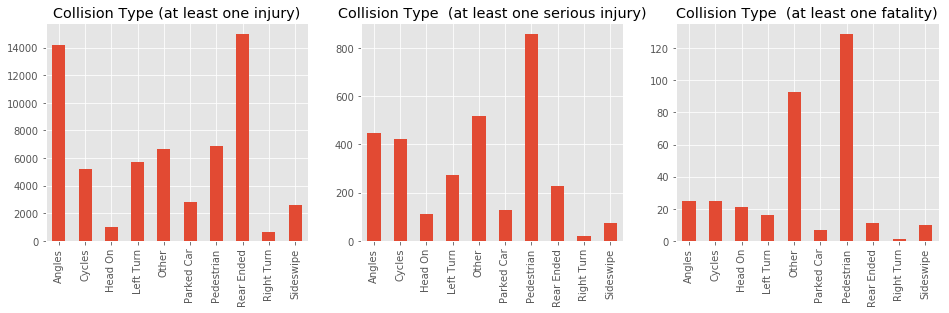

In [105]:
fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 4))
fig.subplots_adjust(hspace=0.8)

df_injury['collisiontype'].value_counts().sort_index().plot(ax=axes[0],kind='bar',title='Collision Type (at least one injury)')
df_serious_injury['collisiontype'].value_counts().sort_index().plot(ax=axes[1],kind='bar',title='Collision Type  (at least one serious injury)')
df_fatality['collisiontype'].value_counts().sort_index().plot(ax=axes[2],kind='bar',title='Collision Type  (at least one fatality)')



#### Question: "Is there a consistent pattern involving collisiontype and injuries/seriousinjuries/fatalities" - Answer; yes and no

Is there a consistent pattern involving collisiontype and injuries/seriousinjuries/fatalities? Only in terms of those that are classified as "Pedestrian" or "Rear End collisions". Serious accidents are more often of type "Pedestrian" than other types. This is even more true for those that involve a fatality. But less serious injury accidents are more often classified as "Rear End" or "Angles".  

#### 4.3 Pedestrians that have right of way

In [106]:
df['pedrownotgrnt'].value_counts().sort_index()

Y    5180
Name: pedrownotgrnt, dtype: int64

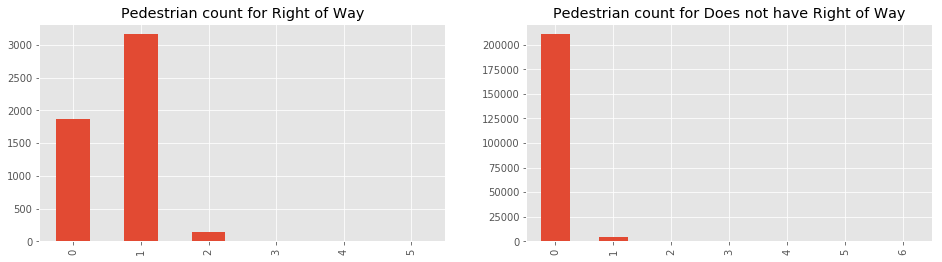

In [107]:
df_ROW=  df.loc[(df["pedrownotgrnt"]=="Y")]
df_Not_ROW= df.loc[(df["pedrownotgrnt"]!="Y")]


fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(16, 4))
fig.subplots_adjust(hspace=0.8)

df_ROW['pedcount'].value_counts().sort_index().plot(ax=axes[0],kind='bar',title='Pedestrian count for Right of Way')
df_Not_ROW['pedcount'].value_counts().sort_index().plot(ax=axes[1],kind='bar',title='Pedestrian count for Does not have Right of Way')



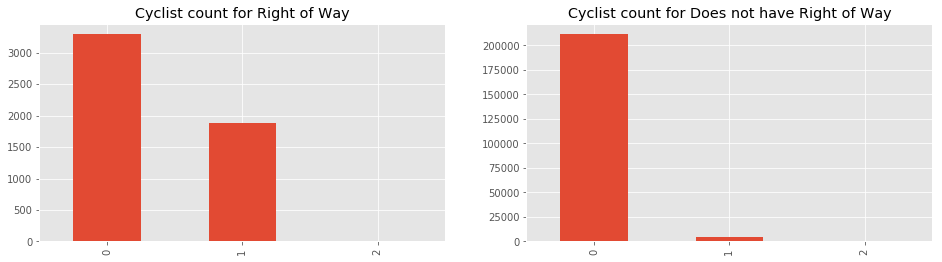

In [108]:

fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(16, 4))
fig.subplots_adjust(hspace=0.8)
df_ROW['pedcylcount'].value_counts().sort_index().plot(ax=axes[0],kind='bar',title='Cyclist count for Right of Way')
df_Not_ROW['pedcylcount'].value_counts().sort_index().plot(ax=axes[1],kind='bar',title='Cyclist count for Does not have Right of Way')


#### Question; "Are there only values for pedrownotgrnt if pedcount > 0 or pedcylcount>0" - Answer; No

Are there only values for pedrownotgrnt if pedcount > 0 or pedcylcount>0 - No, all records initially had values null and Y (we converted null to N) to end up wtih values of Y or N, so, the answer is No. 

#### Let's look at just those that involve pedestrians or cyclists

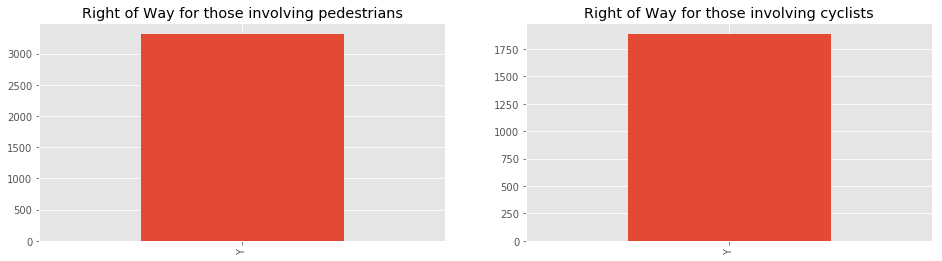

In [109]:
df_Peds=  df.loc[(df["pedcount"]>0)]

df_Cyclists= df.loc[(df["pedcylcount"]>0)]
                   
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(16, 4))
fig.subplots_adjust(hspace=0.8)
df_Peds['pedrownotgrnt'].value_counts().sort_index().plot(ax=axes[0],kind='bar',title='Right of Way for those involving pedestrians')
df_Cyclists['pedrownotgrnt'].value_counts().sort_index().plot(ax=axes[1],kind='bar',title='Right of Way for those involving cyclists')


I guess its about what you would expect.

#### Clean up/combine some values and save to temp file so that I can view in tableau

For categorical features (and st_coldesc & sdot_col), let's go ahead and convert missing values and 'other' to 'Unknown.

For pedrownotgrnt, lets convert null to N so that we have Y/N values.

For underinfl, we can consolidate the existing values, but, for those that are null, let's leave them as X.

In [110]:
categories = ["addrtype", "collisiontype", "severitydesc", "lightcond",
             "speeding", "junctiontype", "roadcond", "weather"]

for col in categories:
    df[col] = df[col].replace({np.nan: "Unknown", "Other": "Unknown"})
    
df["pedrownotgrnt"] = df["pedrownotgrnt"].replace({np.nan: "N"})    

# While we are at it, let's go ahead and clean up missing values for these two:
df["st_coldesc"] = df["st_coldesc"].replace({np.nan: "Unknown"})  
df["sdot_coldesc"] = df["sdot_coldesc"].replace({np.nan: "Unknown"})

df["underinfl"] = df["underinfl"].replace({"0": "N", "1": "Y", np.nan: "X"})


for col in categories+ ['pedrownotgrnt', 'st_coldesc', 'sdot_coldesc' , 'underinfl']:
    print("\n{}: {} unique and {} null".format(col,
                                               df[col].nunique(dropna=False),
                                               df[col].isna().sum())) 
 
# Save records as collisions_clean
df_clean = df.loc[df["fe_emd"] == False]

drop_cols = ["objectid", "status", "inckey",
             "coldetkey", "sdotcolnum",
             "exceptrsncode", "exceptrsndesc", "pedrownotgrnt"]

for col in drop_cols:
    if col in df_clean.columns:
        df_clean.drop(columns=[col], inplace=True)
    else:
        continue
        
clean_local_file_name  = "../data/collisions_with_unknowns.csv"

df_clean.to_csv(clean_local_file_name, encoding="utf-8", index=True, index_label="Id")




addrtype: 4 unique and 0 null

collisiontype: 10 unique and 0 null

severitydesc: 5 unique and 0 null

lightcond: 8 unique and 0 null

speeding: 2 unique and 0 null

junctiontype: 7 unique and 0 null

roadcond: 8 unique and 0 null

weather: 10 unique and 0 null

pedrownotgrnt: 2 unique and 0 null

st_coldesc: 63 unique and 0 null

sdot_coldesc: 41 unique and 0 null

underinfl: 3 unique and 0 null


### Answers

1. Does personcount include pedcount? <font color="blue">**No**</font>


2. Does personcount include pedcylcount? <font color="blue">**No**</font>


3. Does injuries include seriousinjuries? <font color="blue">**No**</font>


4. Does injuries include fatalities? <font color="blue">**No**</font>


5. If the collision is marked as hitparkedcar = Y, does the 'number of vehicles involved' include the pared car? <font color="blue"><b>Yes</b></font>


6. Is there a consistent pattern involving severitydesc and injuries/seriousinjuries/fatalities <font color="blue">**Yes and No - Having a collision classified as Serious is not 100% dependent on there being at least one serious injury. It may depend on other factors, such as; How many people were injured or if a pedestrian or cyclist was involved.**</font>


7. Is there a consistent pattern involving collisiontype and injuries/seriousinjuries/fatalities <font color="blue"> **I found that those that involve more serious injuries and fatalities are more likely to involve pedestrians. Those with less serious injuries are more likely resulting from Rear End or Angle accidents.**</font>


8. Are there only values for pedrownotgrnt (pedestrian has right of way) if pedcount > 0 or pedcylcount>0  <font color="blue">**No. There are only two values for this feature;  null and yes values. So  it is not true that we only have values for those that have  pedcount > 0 or pedcylcount>0.**</font> 

### Summary

There is an interesting pattern in reference to Null vs. Unknown for weather, roadcond and lightcond. There seem to be two subsets of data with similar overlap of missing data.

There are about 26,000 that have null for weather, roadcond and lightcond – and this set also has significant null for underinfl and st_coldesc, mostly zeros for vehcount and personcount as well as 00:00  for time portion of incdttm  (they have date only)

Whereas those that that have ‘Unknown’ weather, roadcond and lightcond, although there is still some overlap (about 10,000) most the other fields do have values.


### Recommendations

- For analysis involving weather, road conditions, counts, collision type and descriptions, I recommend the following;


- Create a feature called fe_ems that is set to true for the following records;

    * weather=null
    * roadcond=null
    * lightcond=null 
    * vehicle count=0
    * collision type='Unknown'  
    * description ='Unknown'
    * severity of collision

- Create a new feature called Total Injuries, this would sum injuries, seriousinjuries and fatalities.
    
    
- In terms of my previous recommendation  about updating vehicle count base on collision descriptions, I have decided this is not a good idea. <font color='darkred'><b> It turns out that he number of times the words 'MOTOR VEHICLE' is found in the collision description is not necessarily the same as the number of vehicles actually involved in the collision.</b></font> 

